### Predicting COVID-19 in the UK using SEIR models

#### Baseline model

Mathematical modeling is an important component in the study of epidemiology and infectious diseases. Especially,compartment models have been used since the 20th century. In this,a population is divided into multiple compartments and individuals in the same compartment are assumed to have the same characteristics. First we introduce and start exploring some baseline models for computational epidemiology: SIR and SI models.

We can use SIR model to forecast the transmission rate of this deadly disease. This model puts each person into one of three categories: susceptible, infectious or resistant. At the beginning initial step, In the initial time step, all patients will be in the infected category and everyone else will be susceptible.

As the time passed,some susceptible people will become infected, while others develop drug resistance. We hypothesized that drug resistance would not be affected again by disease .We assumed a constant population size and those who unfortunately died were classified as resistant. Because they can't spread the virus. 
When the number of infections increases，more susceptible people will contract the disease. Now, the number of cases will grow exponentially. After that，there will be a lot of recovered cases. There will be fewer vulnerable people in contact with infected people. These models exist on diagrams，the vertices or nodes can represent persons, agents, or surfaces that may carry infectious diseases. Edges connecting nodes represent nodes that are in close contact with each other and are at risk of spreading disease.
We will achieve a variant of the SIR model. In the SIR model,  each peak has one of three possible states: -I means infected and at risk of spreading the disease to an adjacent peak of susceptibility-S means susceptible，risk of infection from neighbors --R means removed and no longer at risk of contracting or spreading infection.

The model iteratively evolves, where the following two calculations occur for each discrete time step (a unit of "time"):

The first step：First, consider all the edges connecting the infected with the susceptible. Susceptible vertices are infected independently and with the same probability β for each edge connecting them to infected vertices. Susceptible edges can only be infected once, and are only at risk of being infected by infected nodes (I) at the beginning of each iteration: newly infected nodes do not continue to be infected until the next time step.

The second step：Then, consider all infected (I) vertices that were infected at the beginning of the time step (before step 1) and consider them recovered with R probability γ.
The model can run any number of time steps, but for fairly small charts, we might want to see the number of infections taper off to zero after a period of time. One of the main tasks in predicting a pandemic is to predict the basic reproductive number of the disease.

Since β represents the rate of spread and γ the rate of recovery, this ratio is very important in determining whether the disease is spreading faster than the rate of recovery.

#### SEIR module

SIR model is a well-known and relatively simple compartment model composing of three compartments: susceptibility (s), infection (I) and rehabilitation / death / immunity (R). SIR model has many derivations based on it. We need to focus on the SEIR model including an extra compartment for exposed populations (E) and is usually used for infections with important potential factors, where people have been influenced but have not yet transmitted to others.

dS/dt = - β SI;  dE/dt =  β SI -  ϵ E;  dI/dt =  ϵ E -  γ I;  dR/dt =  γ I;
R0 =  β/γ;
β:  Average exposure rate in the population; 

ε:  The mutual of the average gestation period; 

γ:  Mutual of average infection period


The rate of changing each element in the SEIR model is given by a differential equation which has been defined above. To execute the model, we use these equations to calculate the higher change in value per element per time step (in this case, per day). That is, from day 0, we calculate the increase or decrease of each element on the next day. What we finally get is the time series of the relative frequency of each compartment during the explosion.

The variables (s, e, I and R) shows how many people (or proportion) at a particular time are in each compartment . Since the SEIR model is dangerous, from time to time, the numbers in each compartment may fluctuate and there is a relationship between each state. For example, when more people are exposed / infected, the number of susceptible (s) population decreases, and the disease may not erupt again until most of the population goes back to susceptible (s). The SEIR model includes parameters ,determining the ratio of population from susceptibility (beta), from exposure to infection (epsilon), and from infection to recovery (gamma). 

At last, the background mortality and birth rate of SEIR models may include parameters. However, they are usually assumed to be equal. Any given SEIR model, which should be noted, is based on a specific population and  in-suitable for other populations.


In this report, we mainly use the date from www.ecdc.europa.eu.（https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide）Constructing the SEIR model for COVID-19 in the UK. We optimize the initial model parameter values and perform some simple validation. This report is intended to show the real-world use of data for epidemiological modeling and isn’t used for rigorous scientific interpretation.

In [1]:
from datetime import datetime
import gen3
from gen3.auth import Gen3Auth
from gen3.submission import Gen3Submission
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import json
import requests
from matplotlib.dates import date2num, num2date
from scipy import integrate, optimize
from scipy.integrate import odeint
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


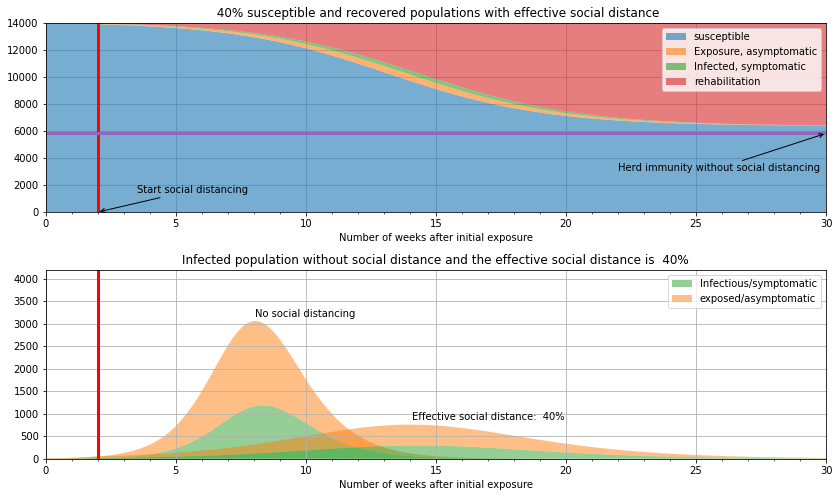

In [2]:
R0 = 2.4 # {type:"slider", min:0.9, max:5, step:0.1}
t_incubation = 5.1 # {type:"slider", min:1, max:14, step:0.1}
t_infective = 3.3 # {type:"slider", min:1, max:14, step:0.1}
# Population distribution
N = 14000 # {type:"slider", min:1000, max:350000, step: 1000}
# Initial exposure
n = 10 # {type:"slider", min:0, max:100, step:1}

# Begin social distancing after contact (weeks)
t_social_distancing = 2 # {type:"slider", min:0, max:30, step:0.1}
# Effectiveness of social distancing (0 to 100%)
u_social_distancing = 40 #@param {type:"slider", min:0, max:100, step:1}

# Initial infections and recoveries
e_initial = n/N
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma

def step(t):
    return 1 if t >= 7*t_social_distancing else 0

# SEIR model's derivative function
def deriv(x, t, u, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -(1-u*step(t)/100)*beta * s * i
    dedt =  (1-u*step(t)/100)*beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]

t = np.linspace(0, 210, 210)
x_initial = s_initial, e_initial, i_initial, r_initial
s, e, i, r = odeint(deriv, x_initial, t, args=(u_social_distancing, alpha, beta, gamma)).T
s0, e0, i0, r0 = odeint(deriv, x_initial, t, args=(0, alpha, beta, gamma)).T

# Plot
fig = plt.figure(figsize=(12, 10))
ax = [fig.add_subplot(311, axisbelow=True), 
      fig.add_subplot(312)]

pal = sns.color_palette()

ax[0].stackplot(t/7, N*s, N*e, N*i, N*r, colors=pal, alpha=0.6)
ax[0].set_title('{0:3.0f}% susceptible and recovered populations with effective social distance'.format(u_social_distancing))
ax[0].set_xlabel('Number of weeks after initial exposure')
ax[0].set_xlim(0, t[-1]/7)
ax[0].set_ylim(0, N)
ax[0].legend([
    'susceptible',
    'Exposure, asymptomatic',
    'Infected, symptomatic',
    'rehabilitation'], 
    loc='best')
ax[0].plot(np.array([t_social_distancing, t_social_distancing]), ax[0].get_ylim(), 'r', lw=3)
ax[0].plot(np.array([0, t[-1]])/7, [N/R0, N/R0], lw=3, label='herd immunity')
ax[0].annotate("Start social distancing",
    (t_social_distancing, 0), (t_social_distancing + 1.5, N/10),
    arrowprops=dict(arrowstyle='->'))
ax[0].annotate("Herd immunity without social distancing",
    (t[-1]/7, N/R0), (t[-1]/7 - 8, N/R0 - N/5),
    arrowprops=dict(arrowstyle='->'))

ax[1].stackplot(t/7, N*i0,N*e0, colors=pal[2:0:-1], alpha=0.5)
ax[1].stackplot(t/7, N*i, N*e, colors=pal[2:0:-1], alpha=0.5)
ax[1].set_title('Infected population without social distance and the effective social distance is {0:3.0f}%'.format(u_social_distancing))
ax[1].set_xlim(0, t[-1]/7)
ax[1].set_ylim(0, max(0.3*N, 1.05*max(N*(e + i))))
ax[1].set_xlabel('Number of weeks after initial exposure')
ax[1].legend([
    'Infectious/symptomatic',
    'exposed/asymptomatic'],
    loc='upper right')
ax[1].plot(np.array([t_social_distancing, t_social_distancing]), ax[0].get_ylim(), 'r', lw=3)

y0 = N*(e0 + i0)
k0 = np.argmax(y0)
ax[1].annotate("No social distancing", (t[k0]/7, y0[k0] + 100))

y = N*(e + i)
k = np.argmax(y)
ax[1].annotate("Effective social distance: {0:3.0f}%".format(u_social_distancing), (t[k]/7, y[k] + 100))

for a in ax:
    a.xaxis.set_major_locator(plt.MultipleLocator(5))
    a.xaxis.set_minor_locator(plt.MultipleLocator(1))
    a.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    a.grid(True)

plt.tight_layout()

In [3]:
def base_seir_model(init_vals, params, t):
    '''
    beta: S --> E, epsilon: E --> I, gamma: I --> R
    '''
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    epsilon, beta, gamma = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (beta * S[-1] * I[-1]) * dt
        next_E = E[-1] + (beta * S[-1] * I[-1] - epsilon * E[-1]) * dt
        next_I = I[-1] + (epsilon * E[-1] - gamma * I[-1]) * dt
        next_R = R[-1] + (gamma * I[-1]) * dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T

To run the simulation with the model, we assign values to each model parameter, specify a set of initial conditions, and then run the function. The parameters of the SEIR model define the conversion rate between compartments. The initial conditions that must be specified are a fixed population size, the number of time steps to be simulated, and the relative frequency of each compartment at time step 0.

#### Set inital state and parameters, running simulation

For the initial run of the model, we use the parameter values estimated by Hellewell . In 2020 (incubation period =5 days, ε=0.2, R0=3.5), the initial conditions are as follows: population size 5,180,493, time window 200 days, initial count of 10 people,1 person infected, the rest of the population is susceptible, meaning that 0 is removed. To derive β, we use γ=0.5, so β=R0*γ=1.75.

In [4]:
# Initial values
N = 5180493
S_0 = (N - 11) / N
E_0 = 10 / N
I_0 = 1 / N
R_0 = 0
init_vals = [S_0, E_0, I_0, R_0]

# Params
epsilon, beta, gamma = [0.2, 1.75, 0.5]
params = epsilon, beta, gamma

# define time interval
t_max = 1000
dt = 1
t = np.linspace(0, t_max, int(t_max / dt) + 1)

# Run simulation
results = base_seir_model(init_vals, params, t)

#### COVID-19 model visualization

We defined a function to plot SEIR model.

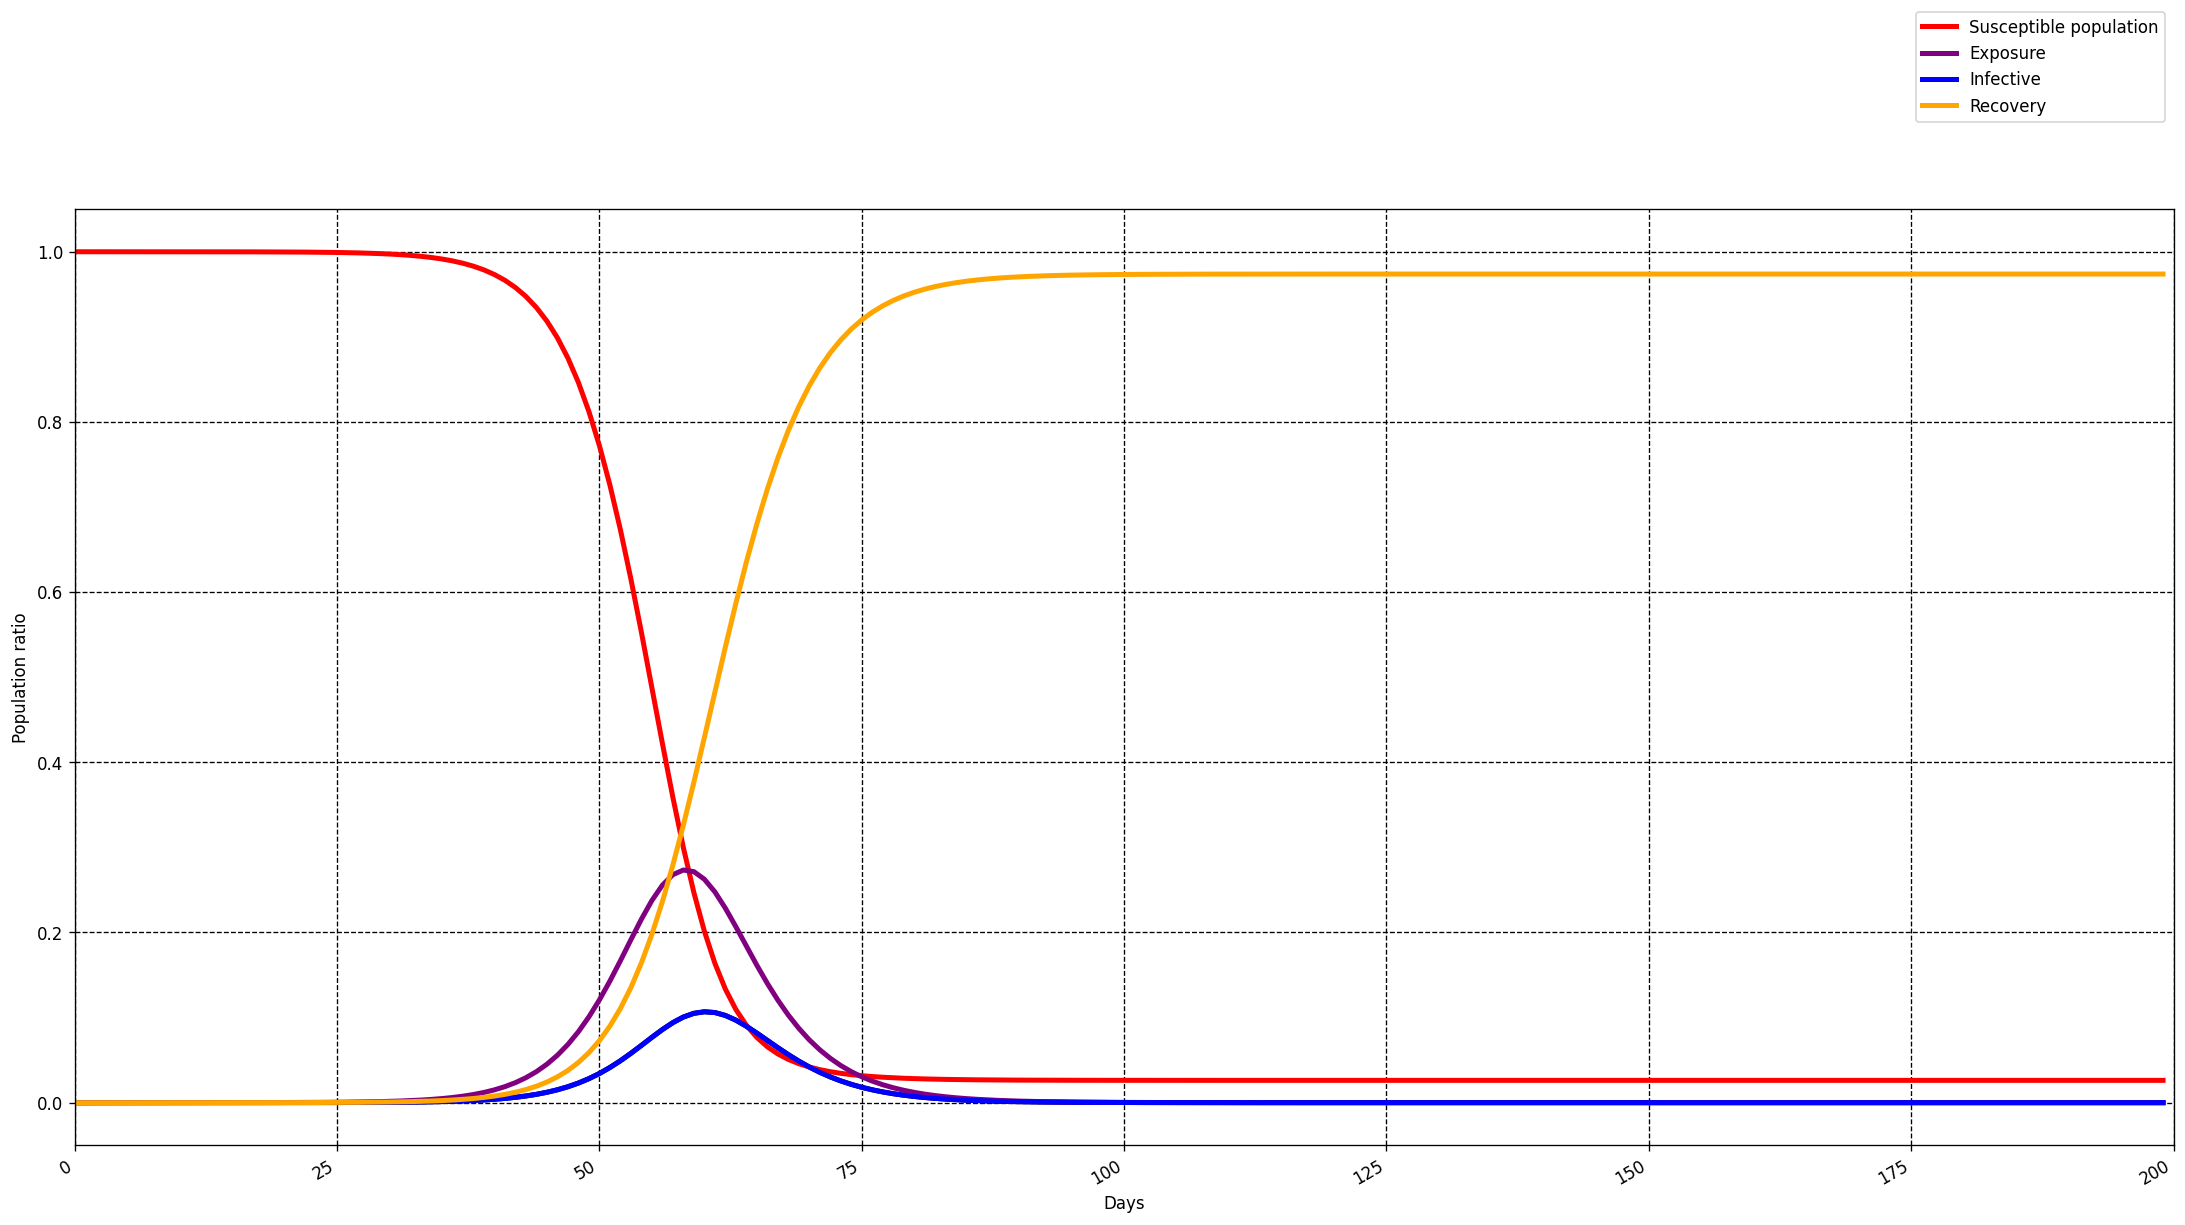

In [5]:
def plot_model(
    simulated_susceptible, simulated_exposure, simulated_infectious, simulated_remove
):
    global times, numTimes
    startInd = 0
    numTimes = len(simulated_infectious)

    fig = plt.figure(figsize=[22, 12], dpi=120)
    fig.subplots_adjust(top=0.85, right=0.92)
    ind = np.arange(numTimes)
    indObs = np.arange(len(simulated_infectious))

    ax = fig.add_subplot(111)
    ax.yaxis.grid(True, color='black', linestyle='dashed')
    ax.xaxis.grid(True, color='black', linestyle='dashed')
    ax.set_axisbelow(True)
    fig.autofmt_xdate()

    (infectedp,) = ax.plot(indObs, simulated_infectious, linewidth=3, color='black')
    (sp,) = ax.plot(ind, simulated_susceptible, linewidth=3, color='red')
    (ep,) = ax.plot(ind, simulated_exposure, linewidth=3, color='purple')
    (ip,) = ax.plot(ind, simulated_infectious, linewidth=3, color='blue')
    (rp,) = ax.plot(ind, simulated_remove, linewidth=3, color='orange')
    ax.set_xlim(0, numTimes)
    ax.set_xlabel('Days')
    ax.set_ylabel('Population ratio')

    plt.legend(
        [sp, ep, ip, rp],
        [
            'susceptible',
            'Exposure, asymptomatic',
            'Infected, symptomatic',
            'rehabilitation'
        ],
        loc='upper right',
        bbox_to_anchor=(1, 1.22),
        fancybox=True,
    )
    
plot_model(results[:200, 0], results[:200, 1], results[:200, 2], results[:200, 3])

Here we plot the relative frequencies of each compartment over time. From day 1, we can see that basically the entire population is susceptible, with very few people being exposed, infected or removed. Tracing the curve to the right, we see that the susceptibility curve drops sharply, the exposure curve and the infection curve have corresponding peaks, and the removal curve rises sharply. As we passed the peak of the contagion curve, we found that compartments quickly stabilized to their long-term values. As the exposure curve and the transmission curve approach zero, the end of the epidemic is near. We observe that by the end of the outbreak, the vast majority of the population will have been infected and subsequently passed through the removed compartments (the removed curve stabilizes at close to 1). Conversely, only a small percentage of the population avoids infection in this simulation (the susceptibility curve stabilizes at close to zero).

#### Compare simulation results with real data

Due to the lack of extensive testing, it is understood that many cases go undetected and are therefore not reflected in the reported case count data. In particular, mild and asymptomatic cases have not been found. While it is not known what percentage of infections end up being mild or asymptomatic, estimates (see paper cited in this article) are as high as 40-50%. This means that any data set can at best provide a highly incomplete picture of the whole situation. Nevertheless, validating the model's simulation results against actual data is the only way to determine whether the model faithfully represents the actual outbreak.

#### Prepare data

In [6]:
df = pd.read_csv('./data/data.csv', parse_dates=['dateRep'])
df = df[(df.countriesAndTerritories == 'United_Kingdom')]
df = df.sort_values(by = 'dateRep')
df = df[['dateRep', 'cases', 'deaths', 'countriesAndTerritories']]
df.rename(columns = {'dateRep': 'date', 'countriesAndTerritories': 'county'}, inplace = True)
df.head(5)

,date,cases,deaths,county
58727,2019-12-31,0,0,United_Kingdom
58726,2020-01-01,0,0,United_Kingdom
58695,2020-01-02,2,0,United_Kingdom
58666,2020-01-03,12,0,United_Kingdom
58635,2020-01-04,4273,403,United_Kingdom


#### Define function to compare

In [7]:
def format_date(x, pos=None):
    thisind = np.clip(int(startInd + x + 0.5), startInd, startInd + numTimes - 1)
    return num2date(times[thisind]).strftime('%m/%d/%Y')

def validate_model(simulated_cases, cases):
    global times, numTimes
    startInd = 0
    times = [date2num(s) for (s) in df.date]
    numTimes = len(simulated_cases)

    fig = plt.figure(figsize=[22, 12], dpi=120)
    fig.subplots_adjust(top=0.85, right=0.92)
    ind = np.arange(numTimes)
    indObs = np.arange(len(simulated_cases))

    ax = fig.add_subplot(111)
    ax.yaxis.grid(True, color='black', linestyle='dashed')
    ax.xaxis.grid(True, color='black', linestyle='dashed')
    ax.set_axisbelow(True)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
    fig.autofmt_xdate()

    (infectedp,) = ax.plot(indObs, simulated_cases, linewidth=3, color='black')
    (si,) = ax.plot(ind, simulated_cases, linewidth=3, color='orange')
    (i,) = ax.plot(ind, cases, linewidth=3, color='blue')
    ax.set_xlim(0, numTimes)
    ax.set_xlabel('Date')
    ax.set_ylabel('Population ratio')

    plt.legend(
        [si, i],
        ['Simulated', 'Actual'],
        loc='upper right',
        bbox_to_anchor=(1, 1.22),
        fancybox=True,
    )

#### Plot

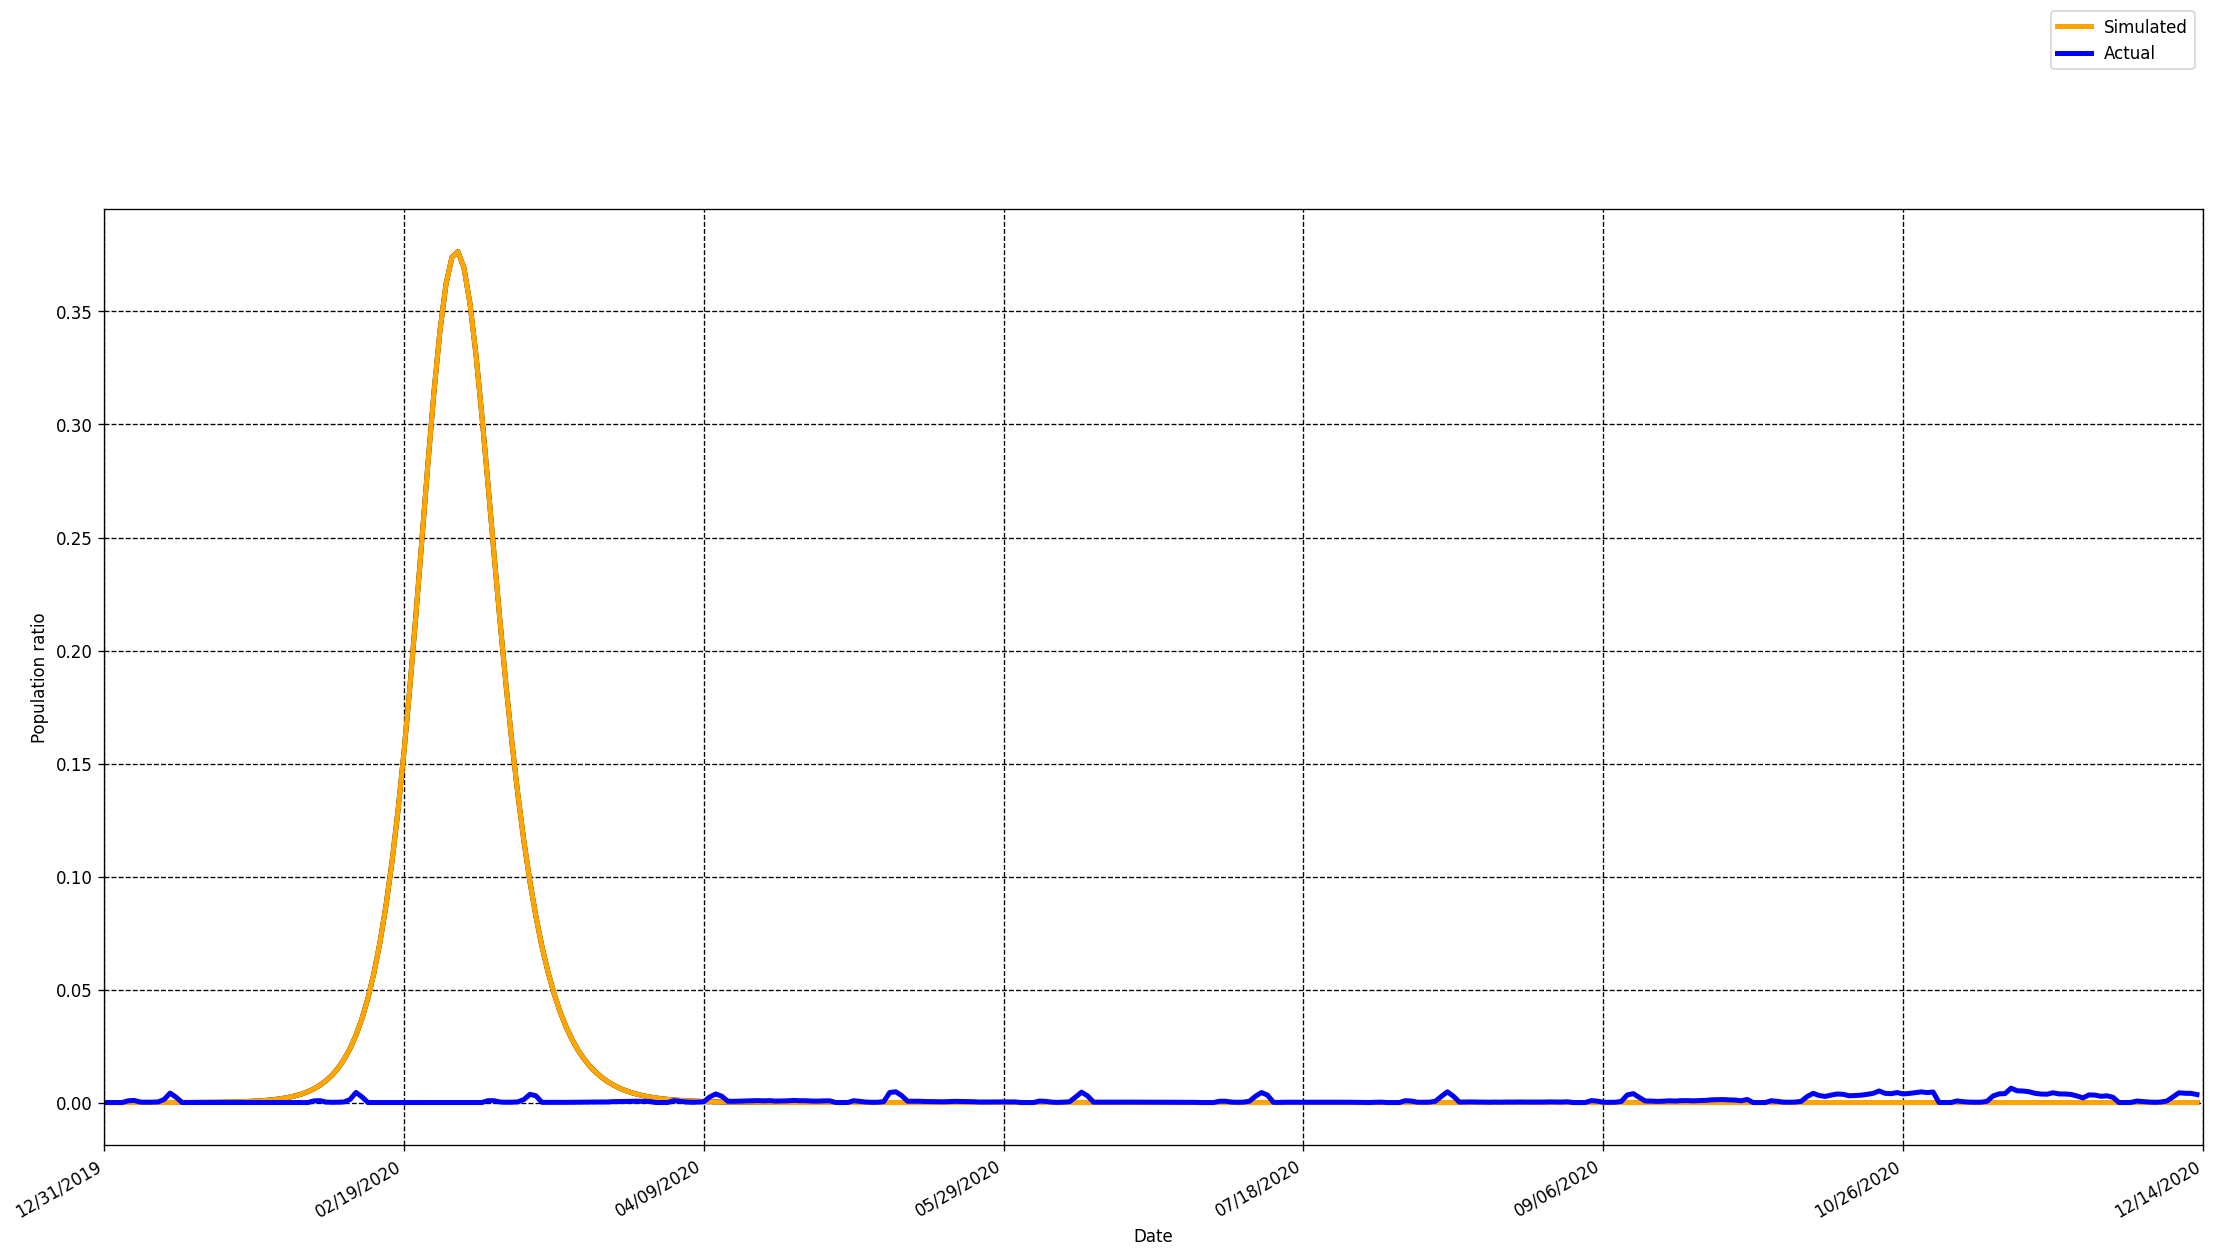

In [8]:
days = len(df.cases)
startInd = 0
cases = results[:days, 1] + results[:days, 2]
validate_model((results[:days, 1] + results[:days, 2]) , (df.cases / N - df.deaths/N))

As expected, the numbers of simulated cases were inconsistent with those reported in Cook County. To improve the accuracy of our predictions, we will use the count of reported cases, deaths, and recoveries in the Cook County dataset to estimate the parameter values of the model. Understanding that we are working with an incomplete and rapidly evolving data set, and therefore the parameter values of the model are difficult to accurately estimate, we still expect to see deviations between the observed data and the simulated results.

#### Parameter optimization

The optimization algorithm evaluates the simulated data using published parameters as a starting point, calculates the differences between the simulated data and the observed data in Cook County, and iteratively updates the parameters using l-BFGs-B method to minimize the differences. We set the maximum iteration to 1E7 and convergence to 1E-8.

In [9]:
class OptimizeModelParameters(object):
    '''SEIR'''
    def __init__(self, init_vals, confirmed):
        self.init_vals = init_vals
        self.confirmed = confirmed

    def evaluate(self, params):
        S_0, E_0, I_0, R_0 = self.init_vals
        S, E, I, R = [S_0], [E_0], [I_0], [R_0]
        epsilon, beta, gamma = params
        dt = 1
        for _ in range(len(self.confirmed) - 1):
            next_S = S[-1] - (beta * S[-1] * I[-1]) * dt
            next_E = E[-1] + (beta * S[-1] * I[-1] - epsilon * E[-1]) * dt
            next_I = I[-1] + (epsilon * E[-1] - gamma * I[-1]) * dt
            next_R = R[-1] + (gamma * I[-1]) * dt
            S.append(next_S)
            E.append(next_E)
            I.append(next_I)
            R.append(next_R)
        return E, I

    def error(self, params):
        '''
        params: Epsilon, beta, gamma
        '''
        yEim, yIim = self.evaluate(params)
        yCim = [sum(i) for i in zip(yEim, yIim)]  
        res = sum(
              np.subtract(yCim, self.confirmed) ** 2
        )
        return res


    def optimize(self, params):
        '''
        params: Epsilon, beta, gamma
        '''
        res = optimize.minimize(
            self.error,
            params,
            method = 'L-BFGS-B',
            bounds = [(0.01, 20.0), (0.01, 20.0), (0.01, 20.0)],
            options = {'xtol': 1e-8, 'disp': True, 'ftol': 1e-7, 'maxiter': 1e8},
        )
        return res

#### Run opimization

In [10]:
# Set up population distribution in initial state
min_ratio = 221000/13816
max_ratio = 442000/13816
infected_cases = df.cases / N - df.deaths / N

# Instantiate the class
min_seir_eval = OptimizeModelParameters(init_vals, infected_cases * min_ratio)
max_seir_eval = OptimizeModelParameters(init_vals, infected_cases * max_ratio)

# Run optimiza function
min_opt_p = min_seir_eval.optimize(params)
max_opt_p = max_seir_eval.optimize(params)

RUNNING THE L-BFGS-B CODE

           * * *




 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91032D+00    |proj g|=  5.14007D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     21      1     0     0   5.140D+00   1.910D+00
  F =   1.9103198758137228     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67196D+00    |proj g|=  5.47472D+00

         

#### Run SEIR model on the actual data

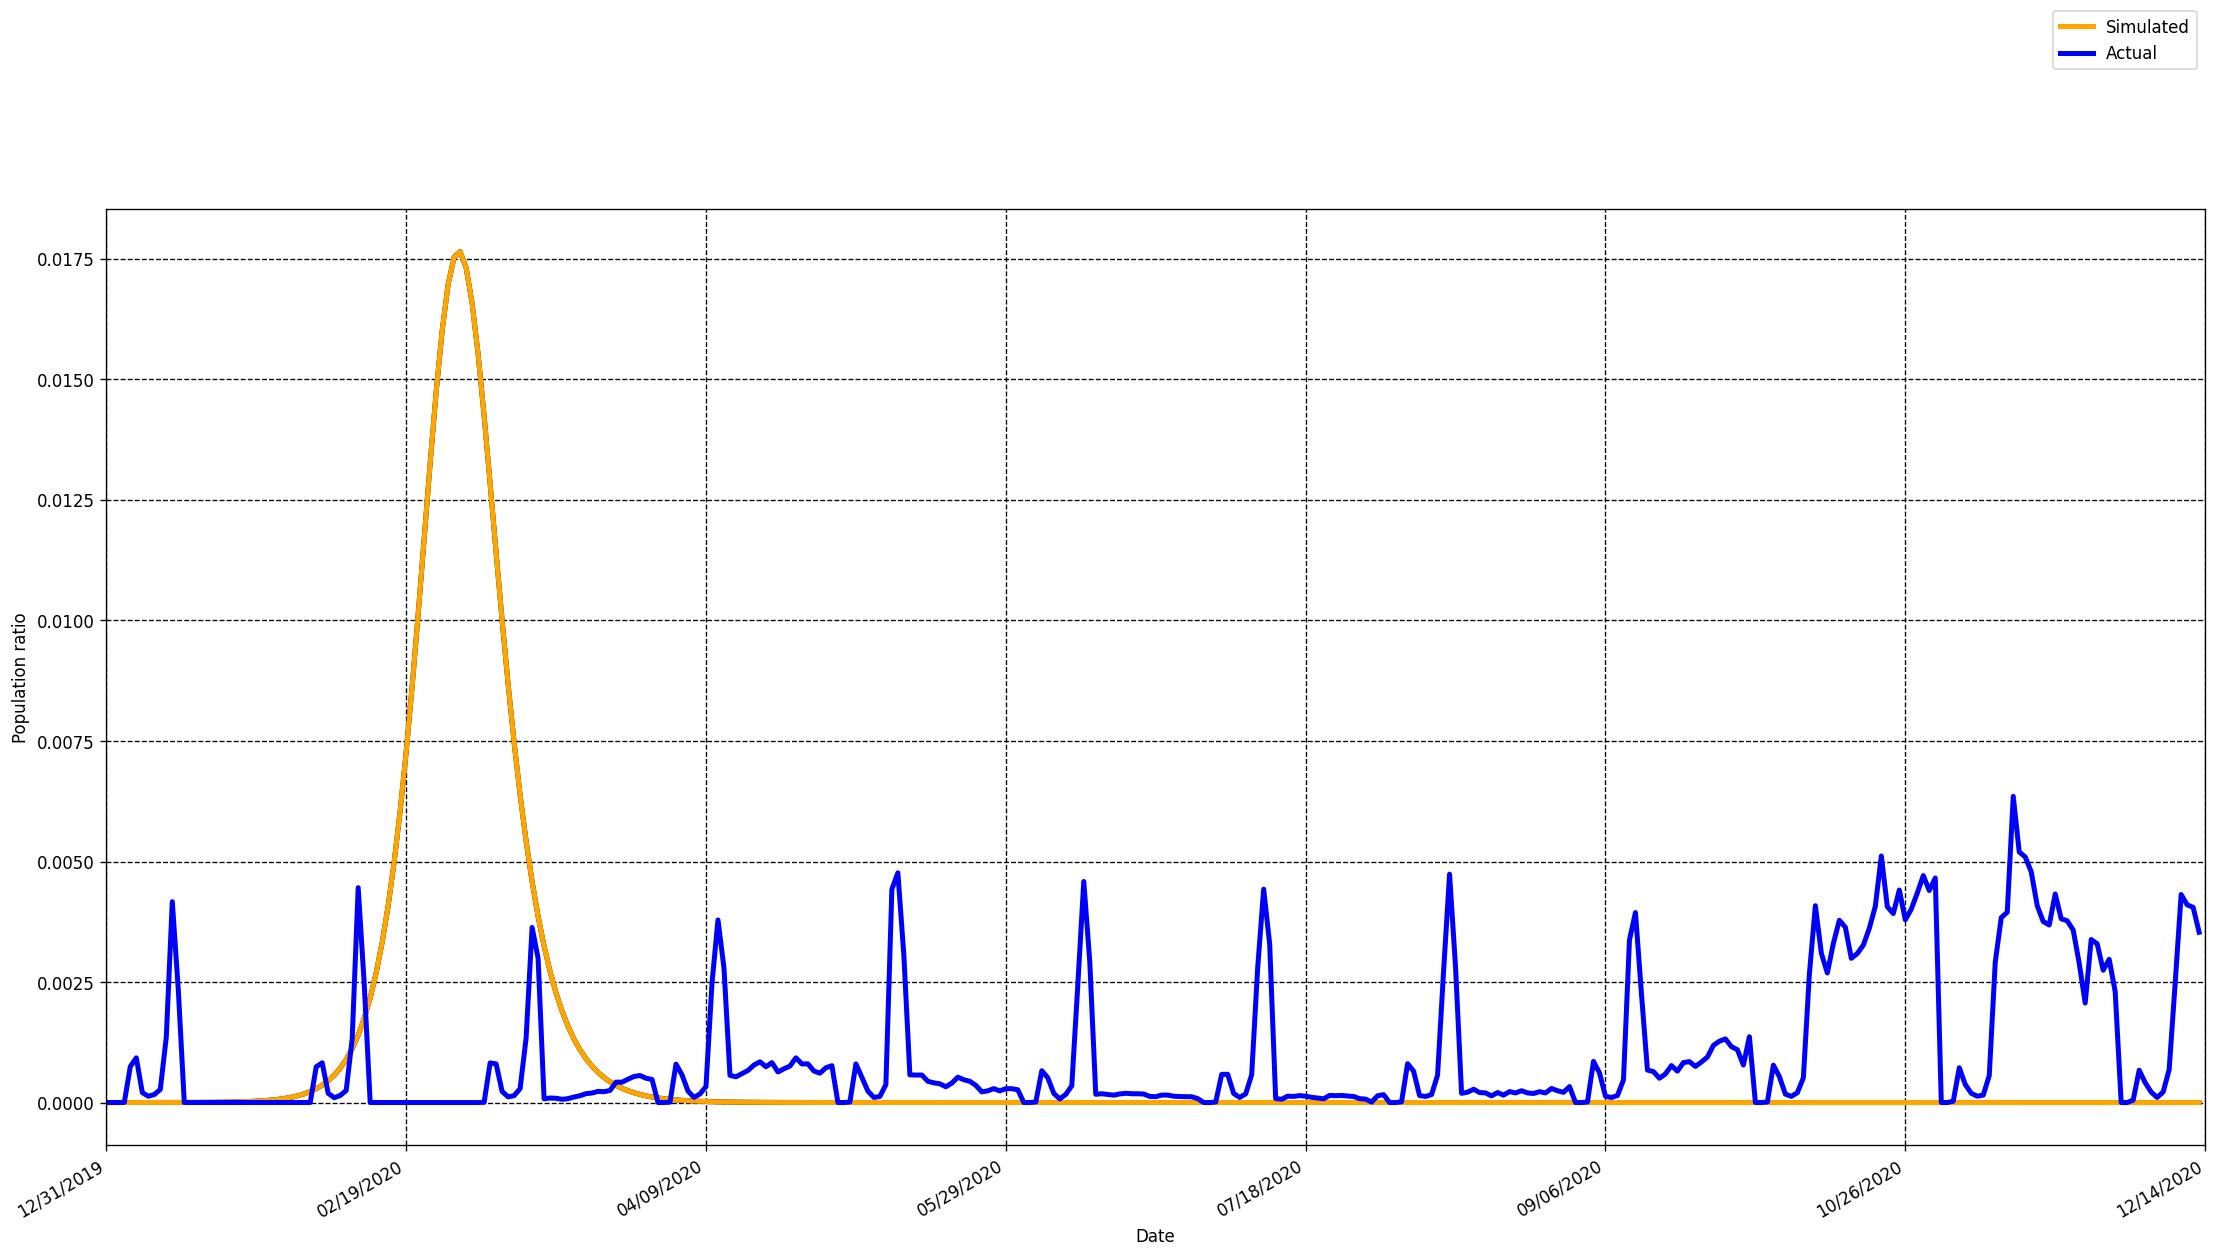

In [11]:
min_results = base_seir_model(init_vals, min_opt_p.x, t)
max_results = base_seir_model(init_vals, max_opt_p.x, t)

min_simulated_cases = (min_results[:days,1] + min_results[:days,2]) * N/min_ratio
min_simulated_cases = [int(x) for x in min_simulated_cases]

max_simulated_cases = (max_results[:days,1] + max_results[:days,2]) * N/max_ratio
max_simulated_cases = [int(x) for x in max_simulated_cases]

avg_simulated_cases = [sum(i)/(2*N) for i in zip(min_simulated_cases, max_simulated_cases)]

validate_model(avg_simulated_cases, df.cases / N - df.deaths / N)

Using optimized parameters, a simulated number of infection cases (exposure + infection) was generated. We then compared simulated infection rates with observed infection rates. The extent to which the predicted proportion of infected cases reflects the actual proportion of infected cases has improved significantly.

#### Run the simulation with optimized parameters

Forecasted maximum confirmed numbers: 553244


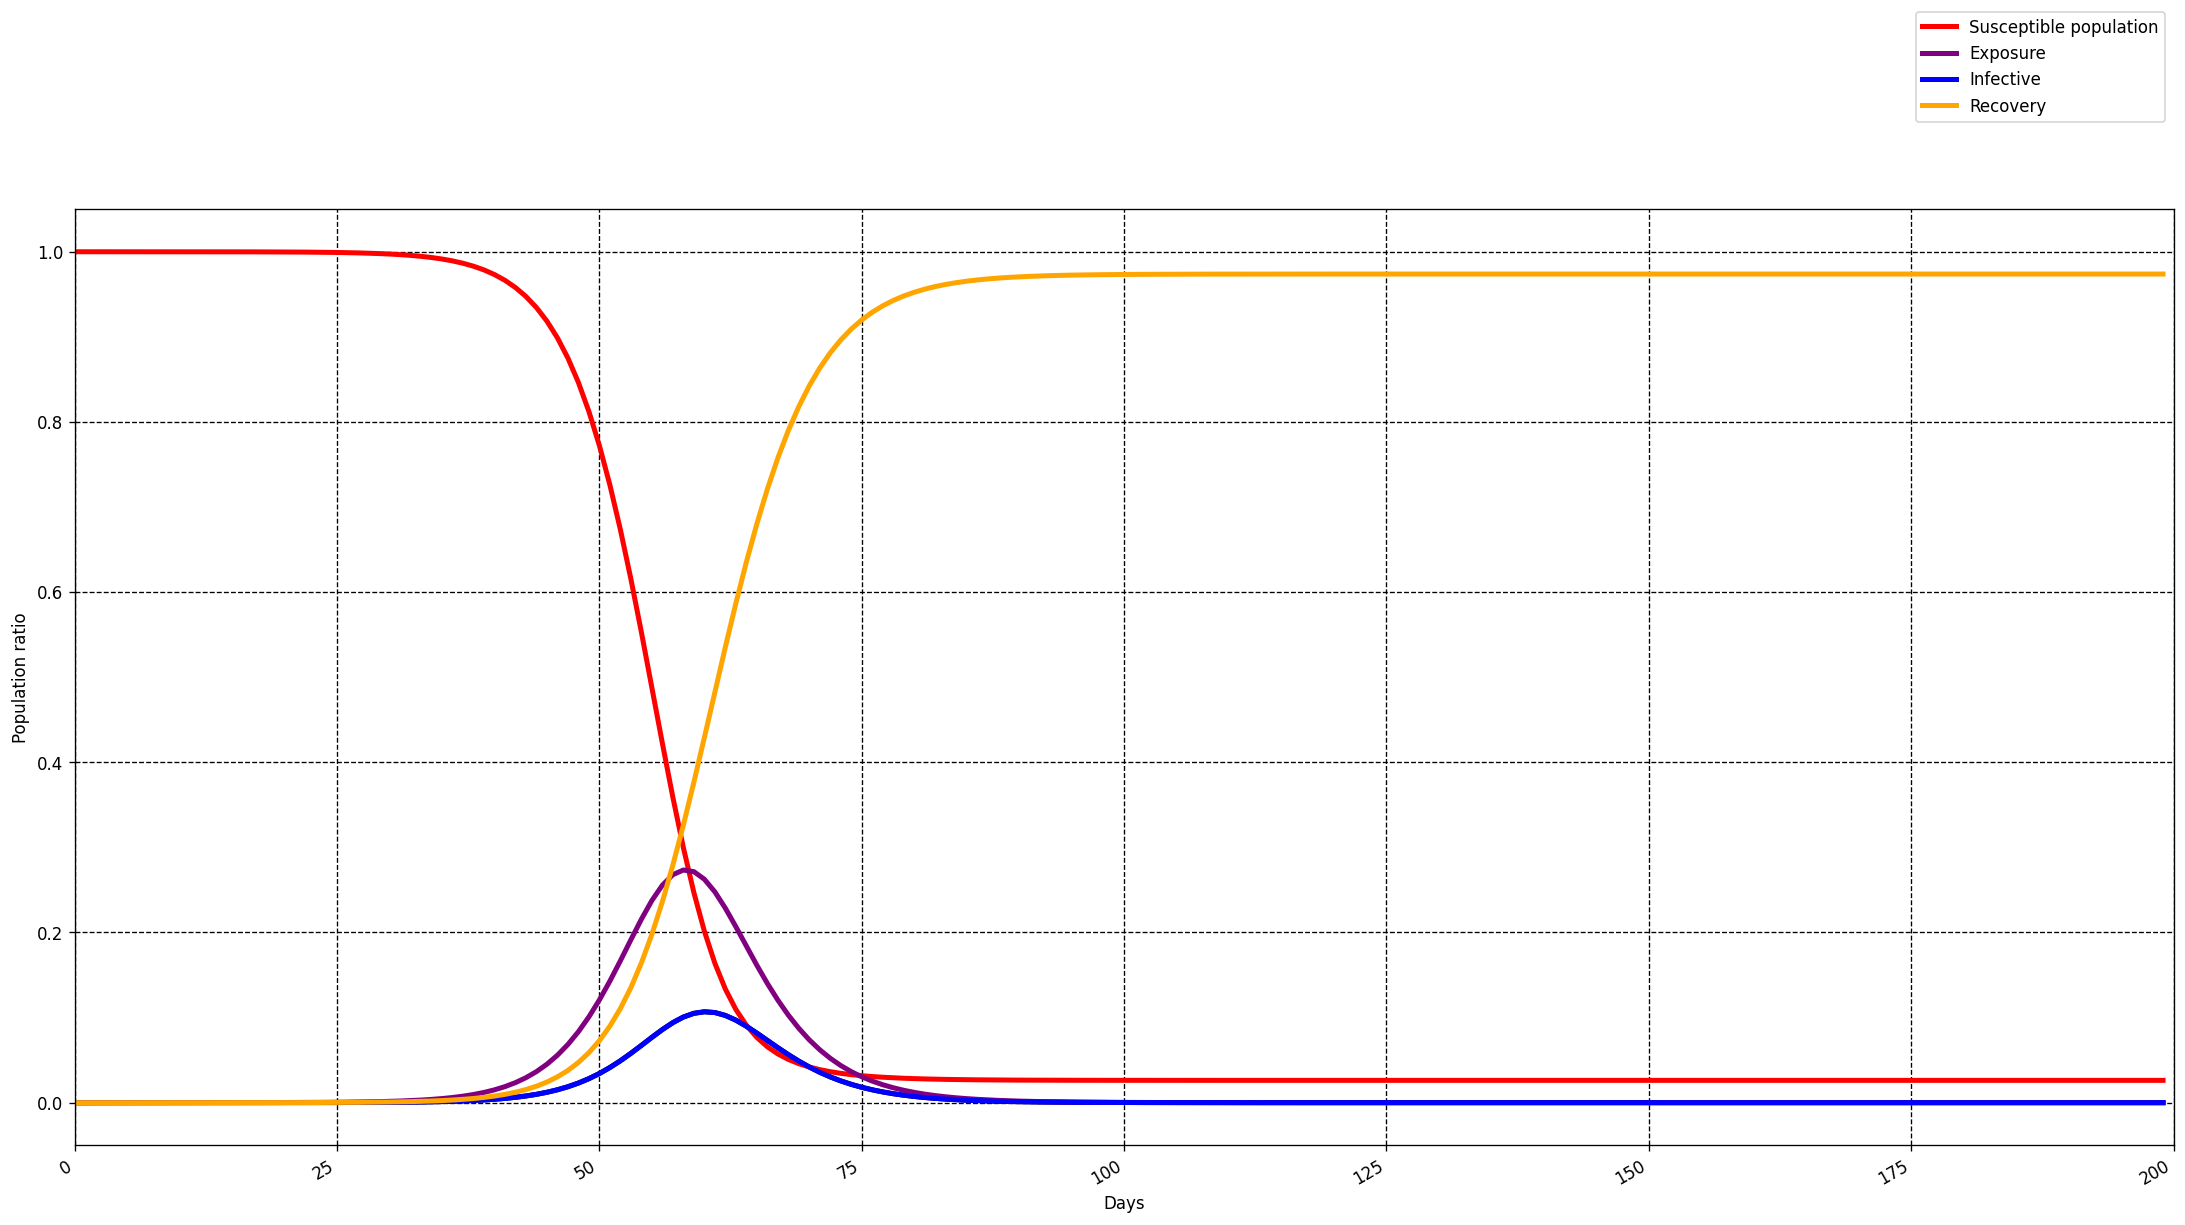

In [12]:
# Run simulation
results = base_seir_model(init_vals, params, t)
print('Forecasted maximum confirmed numbers: %s' % str(int(max(results[:, 2]) * N)))
plot_model(results[:200, 0], results[:200, 1], results[:200, 2], results[:200, 3])

In the end, we plot the relative frequencies of each SEIR compartment over time when using optimization parameters.

#### Conclusions

Our report demonstrates the relatively simple use of data from COVID-19 in the UK to build an optimized SEIR model. Because the COVID-19 pandemic is an ongoing event, these data are regularly updated.
Our model does not capture the "second wave" we observe in real data, and does not take into account shifts in activity and their impact on disease transmission. Our model assumes immunity after recovery -- which has not been proven or disproved. Our model Our model does not take into account other factors such as age, immune deficiency and groups that may be more affected than others. In addition, models are extremely sensitive to perturbations -- small changes in parameters can lead to significant changes in the number of people in the exposure and infection categories.

#### References

Data: https://engmaths.github.io/emat10006/assignment/

Github doc: https://docs.github.com/cn/get-started/writing-on-github/getting-started-with-writing-and-formatting-on-github/basic-writing-and-formatting-syntax